#Imports

In [ ]:
#Import das libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import datetime as dt
from datetime import timedelta
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import (GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
plt.style.use("ggplot")

pd.set_option('display.max_rows', 200)

In [ ]:
!pip install --upgrade xgboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

     |████████████████████████████████| 166.7MB 69kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Calibri"
plt.style.use("ggplot")
teal = "#00C0D2"
light_blue = "#4251BC"
blue = "#262E6C"
dark_blue = "#111530"
black = "#000000"
cian = "#4AA6EE"

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df_demanda = pd.read_csv('/content/drive/Shared drives/VAI Academy  - Conteúdo/1. Ciência de Dados na Prática/2. Hard Skills/5. Machine Learning II/3. Encontro - Modelagem supervisionada II & Séries Temporais/Nova Aula/Case/Dados/Histórico Demanda Elétrica Peru 2006  - Gabarito.csv',sep=',', header=0)
df_temp = pd.read_csv('/content/drive/Shared drives/VAI Academy  - Conteúdo/1. Ciência de Dados na Prática/2. Hard Skills/5. Machine Learning II/3. Encontro - Modelagem supervisionada II & Séries Temporais/Nova Aula/Case/Dados/Tempo Lima 2006 - 2021.csv',sep=',', header=0)



#1 - Análise Exploratória


##1.1 - Data Prep

###Preparação dos dados de temperatura

In [ ]:
#Temperatura
df_tempo = df_temp.copy()
df_tempo["DATETIME"] = df_tempo["DATE"] + " " + df_tempo["HOUR"]
df_tempo["DATETIME"] = pd.to_datetime(df_tempo["DATETIME"])
df_tempo = df_tempo.drop(columns=['DATE','HOUR'])
df_tempo = df_tempo.dropna()
#df_tempo.drop_duplicates(subset=['DATETIME'])

#Upsample e interpolação
df_tempo.set_index("DATETIME", inplace=True)
df_tempo = df_tempo.resample('15min').interpolate(method='linear')

###Preparação dos dados de potência

In [ ]:
#Demanda Potencia
df_demanda_potencia = df_demanda.copy()
df_demanda_potencia["Date"] = pd.to_datetime(df_demanda_potencia["date"])
df_demanda_potencia = df_demanda_potencia.drop(columns=["date"])
df_demanda_potencia["dataref"] = df_demanda_potencia["Date"].dt.strftime("%Y%m%d")
df_demanda_potencia["ano"] = df_demanda_potencia["Date"].dt.year
df_demanda_potencia["mes"] = df_demanda_potencia["Date"].dt.month
df_demanda_potencia["semana"] = df_demanda_potencia["Date"].dt.week
df_demanda_potencia["dia"] = df_demanda_potencia["Date"].dt.day
df_demanda_potencia["dia_semana"] = df_demanda_potencia["Date"].dt.dayofweek
df_demanda_potencia["hora"] = df_demanda_potencia["Date"].dt.hour
df_demanda_potencia["minuto"] = df_demanda_potencia["Date"].dt.minute
df_demanda_potencia["hora-minuto"] = df_demanda_potencia["Date"].dt.strftime('%H:%M')
df_demanda_potencia.set_index("Date", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [ ]:
#Marca pico
df_demanda_potencia2 = df_demanda_potencia[(17 <= df_demanda_potencia["hora"]) & (df_demanda_potencia["hora"] <= 23)]
df_demanda_potencia2["max_executado"] = df_demanda_potencia2.groupby("dataref")["executado"].transform("max")
df_demanda_potencia2["pico"] = (df_demanda_potencia2["executado"] == df_demanda_potencia2["max_executado"])
df_demanda_potencia = df_demanda_potencia.merge(df_demanda_potencia2[["Date", "pico"]], on="Date", how="left")
df_demanda_potencia.loc[pd.isnull(df_demanda_potencia["pico"]), "pico"] = False
df_demanda_potencia["pico"] = df_demanda_potencia["pico"].astype(int)
df_demanda_potencia.set_index("Date", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


##1.2 - EDA

###Como se comporta a demanda elétrica ao longo dos anos, meses, semanas, dias?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


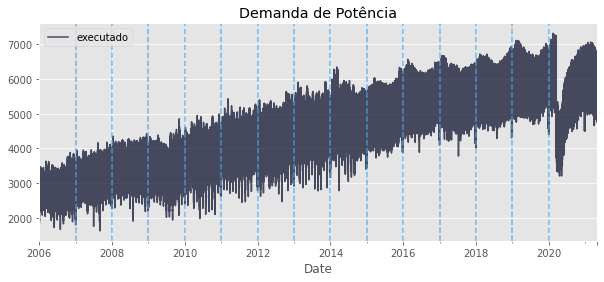

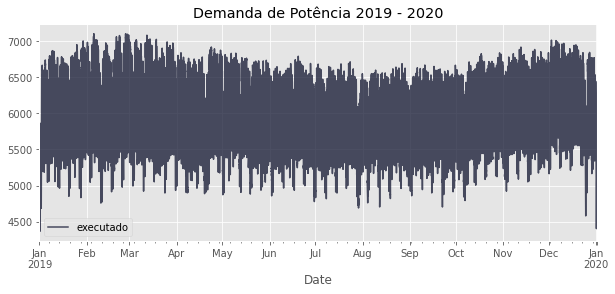

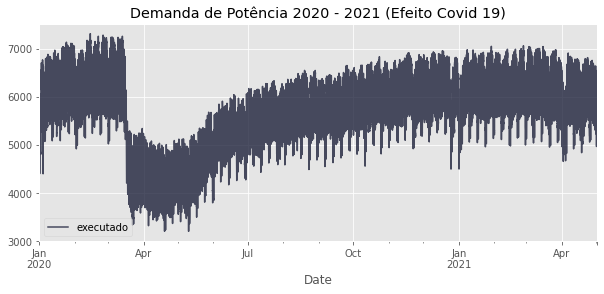

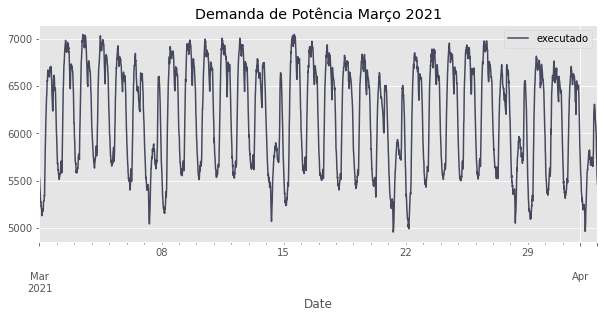

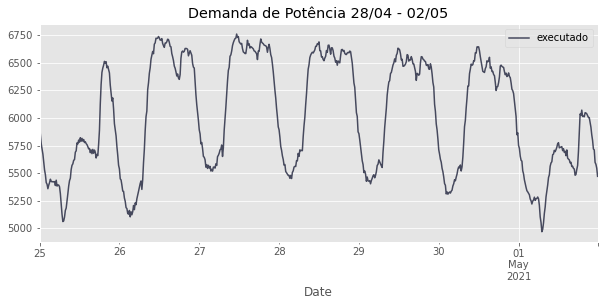

In [ ]:
#Plots
ax = df_demanda_potencia.plot(
    y="executado", figsize=(10, 4), title="Demanda de Potência", c=dark_blue, alpha=0.75,
)
for y in np.arange(2000, 2021):
    ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
plt.show()

df_demanda_potencia.loc["2019-01-01":"2020-01-01"].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência 2019 - 2020",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

df_demanda_potencia.loc["2020-01-01":"2021-05-01"].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência 2020 - 2021 (Efeito Covid 19)",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

df_demanda_potencia.loc["2021-03-01":"2021-04-01"].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência Março 2021",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

df_demanda_potencia.loc["2021-04-25":"2021-05-01"].plot(
    y="executado",
    figsize=(10, 4),
    title="Demanda de Potência 28/04 - 02/05",
    c=dark_blue,
    alpha=0.75,
)

In [ ]:
#Podemos modelar o crescimento esperado da demanda?
df_demanda_potencia["DATE"] = pd.to_datetime(df_demanda_potencia.index)
df_demanda_potencia["ORDINAL_DATE"] = df_demanda_potencia["DATE"].apply(
    lambda x: time.mktime(x.timetuple())
)


lin_regr = LinearRegression(fit_intercept=True)
x = df_demanda_potencia.dropna(subset=["executado", "ORDINAL_DATE"])[
    "ORDINAL_DATE"
].values.reshape(-1, 1)
y = df_demanda_potencia.dropna(subset=["executado", "ORDINAL_DATE"])["executado"].values.reshape(
    -1, 1
)

lin_regr.fit(x, y)
print("LinReg Slope (per timestep):", lin_regr.coef_[0])
print("LinReg Intercept:", lin_regr.intercept_)
print("LinReg Slope (per month):", lin_regr.coef_[0] * 48 * 30)
print("LinReg Slope (per year):", lin_regr.coef_[0] * 48 * 365)

LinReg Slope (per timestep): [7.40363832e-06]
LinReg Intercept: [-5661.20641167]
LinReg Slope (per month): [0.01066124]
LinReg Slope (per year): [0.12971174]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]


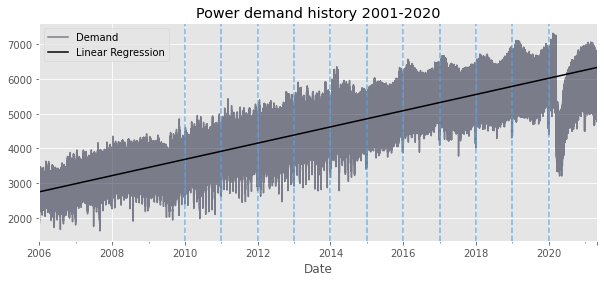

In [ ]:
df_demanda_potencia["LINREG"] = lin_regr.predict(
    df_demanda_potencia["ORDINAL_DATE"].values.reshape(-1, 1)
)
ax = df_demanda_potencia.plot(
    y="executado",
    figsize=(10, 4),
    title="Power demand history 2001-2020",
    c=dark_blue,
    alpha=0.5,
    label="Demand",
)
for y in np.arange(2010, 2021):
    ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
df_demanda_potencia.plot(y="LINREG", figsize=(10, 4), c="k", ax=ax, label="Linear Regression")
plt.show()

###Distribuição da Demanda

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Distribuição de Probabilidade da Demanda 2018-2021')

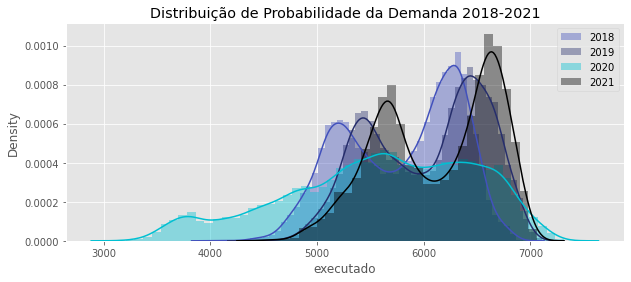

In [ ]:
ax = sns.distplot(
    df_demanda_potencia.loc["2018-01-01":"2019-01-01"]["executado"], label="2018", color=light_blue,
)

sns.distplot(
    df_demanda_potencia.loc["2019-01-01":"2020-01-01"]["executado"],
    label="2019",
    color=blue,
    ax=ax,
)
sns.distplot(
    df_demanda_potencia.loc["2020-01-01":"2021-01-01"]["executado"],
    label="2020",
    color=teal,
    ax=ax,
)
sns.distplot(
    df_demanda_potencia.loc["2021-01-01":"2021-05-01"]["executado"],
    label="2021",
    color=black,
    ax=ax,
)
ax.legend()
ax.set_title("Distribuição de Probabilidade da Demanda 2018-2021")

*Insight 1: A demanda segue uma distribuição de probabilidade bimodal com deslocamento ano após ano.
As modas são gerados pela sasonalidade diária de picos (diurno) e vales (noturno).*

*Insight 2: 2020 ocorre uma mudança do padrão, marcado por um espessamento da cauda à esquerda*

###Estudo dos Picos

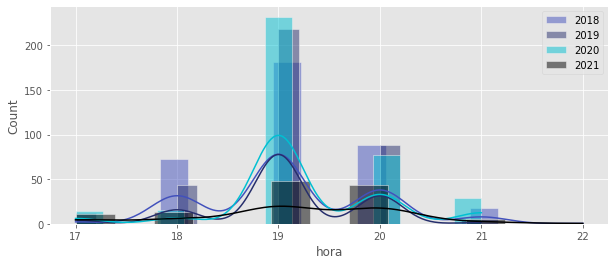

In [ ]:
#Como se dá a ocorrência dos picos ao longo dos anos?
df_demanda_pico = df_demanda_potencia[df_demanda_potencia["pico"] == 1].copy()


ax = sns.histplot(
    df_demanda_pico.loc["2018-01-01":"2019-01-01"]["hora"], label="2018", color=light_blue, kde=True
)
sns.histplot(
    df_demanda_pico.loc["2019-01-01":"2020-01-01"]["hora"], label="2019", color=blue, ax=ax,kde=True
)
sns.histplot(
    df_demanda_pico.loc["2020-01-01":"2021-01-01"]["hora"], label="2020", color=teal, ax=ax,kde=True
)
sns.histplot(
    df_demanda_pico.loc["2021-01-01":"2021-05-01"]["hora"], label="2021", color=black, ax=ax,kde=True
)

ax.legend()

*Insight: Há uma clara mudança do padrão de ocorrência do pico intra diário a partir de 2021, onde a densidade em torno das 20h passa a ser tão significante quanto em torno das 19h*

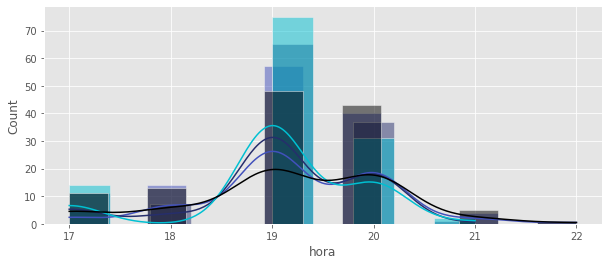

In [ ]:
#Plot do primeiro semestre de cada ano
ax = sns.histplot(
    df_demanda_pico.loc["2018-01-01":"2018-05-01"]["hora"], label="2018", color=light_blue, kde=True
)
sns.histplot(
    df_demanda_pico.loc["2019-01-01":"2019-05-01"]["hora"], label="2019", color=blue, ax=ax,kde=True
)
sns.histplot(
    df_demanda_pico.loc["2020-01-01":"2020-05-01"]["hora"], label="2020", color=teal, ax=ax,kde=True
)
sns.histplot(
    df_demanda_pico.loc["2021-01-01":"2021-05-01"]["hora"], label="2021", color=black, ax=ax,kde=True
)

*Insight: filtrando-se apenas os primeiros semestres dos anos anteriores, confirma-se a mudança do comportamento da distribuição*

###Temperatura

In [ ]:
df_tempo.head()

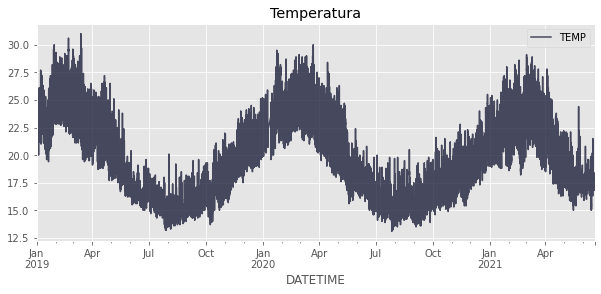

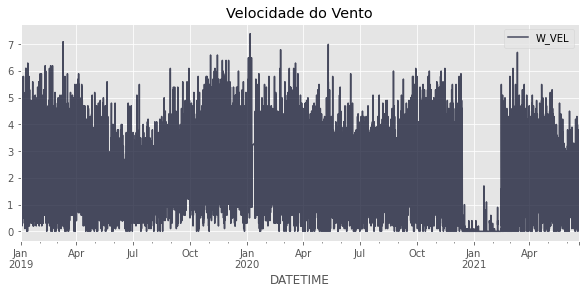

In [ ]:
#Plots
ax = df_tempo["2019-01-01":].plot(
    y="TEMP", figsize=(10, 4), title="Temperatura", c=dark_blue, alpha=0.75,
)
df_tempo["2019-01-01":].plot(
    y="W_VEL",
    figsize=(10, 4),
    title="Velocidade do Vento",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

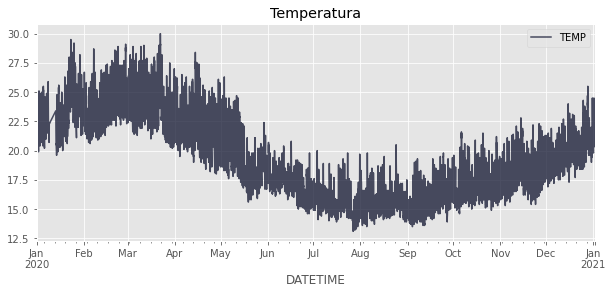

In [ ]:
#Plots
ax = df_tempo.loc["2020-01-01":"2021-01-01"].plot(
    y="TEMP", figsize=(10, 4), title="Temperatura", c=dark_blue, alpha=0.75,
)

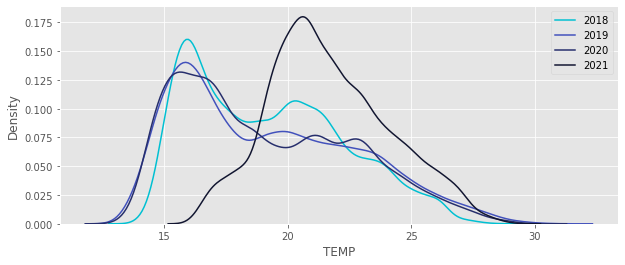

In [ ]:
ax = sns.kdeplot(
    df_tempo.loc["2018-01-01":"2019-01-01"]["TEMP"], label="2018", color=teal,  
)
sns.kdeplot(
    df_tempo.loc["2019-01-01":"2020-01-01"]["TEMP"], label="2019", color=light_blue, ax=ax, 
)
sns.kdeplot(
    df_tempo.loc["2020-01-01":"2021-01-01"]["TEMP"], label="2020", color=blue, ax=ax, 
)
sns.kdeplot(
    df_tempo.loc["2021-01-01":"2021-05-01"]["TEMP"], label="2021", color=dark_blue, ax=ax, 
)

ax.legend()

#2 - Feature engineering

In [ ]:
#Feature Engineering
#Busca feriados peruanos
peru_holidays = holidays.Peru()
dates_of_holidays = []
for date, name in sorted(
    holidays.Peru(
        years=[2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019, 2020, 2021]
    ).items()
):
    dates_of_holidays.append(date)

def criaFeatures(df):
  #Coluna temporaria
  df['temp'] = df.index.to_pydatetime()
  #Features de Data
  df["Holiday"] = df['temp'].apply(lambda t: 1 if t.date() in dates_of_holidays else 0)
  df["Quarter"] = df["temp"].apply(lambda t: t.quarter)
  df["DayOfYear"] = df["temp"].apply(lambda t: t.dayofyear)
  df["WeekOfYear"] = df["temp"].apply(lambda t: t.weekofyear)
  #Features auto correlacionadas
  df['lag_1'] = df['executado'].shift(1, freq = 'D')
  df['lag_7'] = df['executado'].shift(7, freq = 'D')
  df['lag_14'] = df['executado'].shift(14, freq = 'D')
  df['rolling_mean_1'] = df['executado'].rolling(window=96).mean()
  df['rolling_mean_7'] = df['executado'].rolling(window=672).mean()
  df['rolling_mean_14'] = df['executado'].rolling(window=1344).mean()
  df = df.drop(columns=["temp"], inplace=True)

criaFeatures(df_demanda_potencia)

In [ ]:
#Junta com dados de temperatura
df_completo = df_demanda_potencia.join(df_tempo, lsuffix='', rsuffix='')

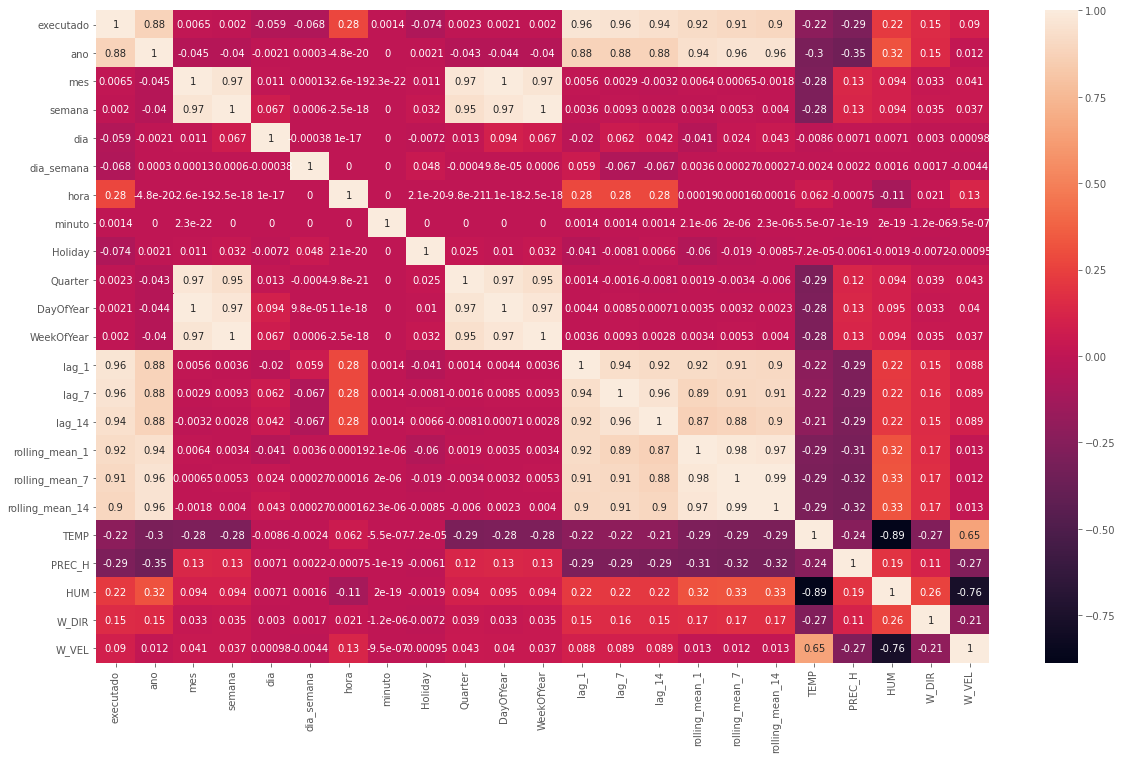

In [ ]:
plt.figure(figsize=(20,12))
corr = df_completo.corr()
sns.heatmap(corr, annot=True)
plt.show()

#3 - Construção do Modelo

In [ ]:
#Gridsearch
df_train_xg = df_completo.loc["2017-01-01":"2021-05-01-00:00"]
df_test_xg = df_completo.loc["2021-05-01-00:00":"2021-05-02-00:00"]

In [ ]:
X_train_xg = df_train_xg.drop(columns=["executado","hora-minuto","dataref"])
y_train_xg = df_train_xg["executado"]
X_test_xg = df_test_xg.drop(columns=["executado","hora-minuto","dataref"])
y_test_xg = df_test_xg["executado"]

cv = TimeSeriesSplit(n_splits=5)

parameters = {"learning_rate": [0.1, 0.05],
              #The learning rate is the shrinkage you do at every step you are making

               "gamma" : [0.01, 0.1, 0.3, 0.5],
              #A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
              #Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
              
               "max_depth": [2, 4, 7, 10],
              #The maximum depth of a tree, same as GBM.
              #Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.

               "colsample_bytree": [0.3, 0.6],
              #Denotes the fraction of columns to be randomly samples for each tree.

               "subsample": [0.2, 0.4, 0.5],
              #Denotes the fraction of observations to be randomly samples for each tree.
              #Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

               "reg_alpha": [0, 0.5, 1],
              #L1 regularization term on weights. Increasing this value will make model more conservative.

               "reg_lambda": [1, 1.5, 2, 3, 4.5],
              #L2 regularization term on weights. Increasing this value will make model more conservative.

               "min_child_weight": [1, 3, 5, 7],
              #The larger min_child_weight is, the more conservative the algorithm will be.

               "n_estimators": [100, 250, 500]}
              #Number of tress or rounds. The more, the higher the risk of overfitting

xgbr = xgb.XGBRegressor(objective='reg:squarederror' , sampling_method = 'gradient_based', tree_method = 'gpu_hist')

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgbr, param_distributions = parameters,  verbose = 3, random_state = 40, cv=cv)

# Fit the model
model_xgboost = xgb_rscv.fit(X_train_xg, y_train_xg)

#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3, score=0.942, total=   1.2s
[CV] subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3, score=0.940, total=   1.2s
[CV] subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV]  subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3, score=0.952, total=   1.3s
[CV] subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3, score=0.835, total=   1.6s
[CV] subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3 
[CV]  subsample=0.4, reg_lambda=3, reg_alpha=0.5, n_estimators=500, min_child_weight=3, max_depth=4, learning_rate=0.05, gamma=0.3, colsample_bytree=0.3, score=0.952, total=   1.7s
[CV] subsample=0.4, reg_lambda=2, reg_alpha=1, n_estimators=250, min_child_weight=7, max_depth=2, learning_rate=0.1, gamma=0.5, colsample_bytree=0.6 
[

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


In [ ]:
model_xgboost.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=3, sampling_method='gradient_based', scale_pos_weight=1,
             subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.3, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=np.nan, monotone_constraints='()',
             n_estimators=500, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=3, sampling_method='gradient_based', scale_pos_weight=1,
             subsample=0.4, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

#4 - Backtest

In [ ]:
#MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def expandingWindowDiario(df, test_start_date, stop_date):
  mae_modelo = []
  mape_modelo = []
  column_names = ["Date", "Executado"	,"EXECUTADO_MODELO"]
  df_previsao = pd.DataFrame(columns = column_names)
  train_start_date = dt.datetime(2017,1,1,0,0,0)
  train_end_date = test_start_date
  test_end_date = test_start_date + timedelta(hours = 24)
  while test_start_date < stop_date:
    print("TRAIN:",train_start_date," - ",train_end_date)
    print("TEST:",test_start_date," - ",test_end_date)

    df_train=df.loc[train_start_date:train_end_date].copy()
    df_test=df.loc[test_start_date:test_end_date].copy()

    X_training = df_train.drop(columns=["executado","hora-minuto","dataref"]).copy()
    y_training = df_train["executado"].copy()
    X_test = df_test.drop(columns=["executado","hora-minuto","dataref"]).copy()
    y_test = df_test["executado"].copy()
    reg.fit(X_training, y_training,
          verbose=False)
    yhat = reg.predict(X_test)
    #Erro
    maeTeste = mean_absolute_error(y_test,yhat)
    mae_modelo.append(maeTeste)
    mape_teste = mean_absolute_percentage_error(y_test,yhat)
    mape_modelo.append(mape_teste)
    d = {'Date' :y_test.index ,'Real':y_test,'Modelo':yhat}
    previsao = pd.DataFrame(data=d)
    df_previsao=df_previsao.append(previsao)
    #Avança
    train_end_date = train_end_date + timedelta(days = 1)
    test_start_date = test_start_date + timedelta(days = 1)
    test_end_date = test_end_date + timedelta(days = 1)
  return ([df_previsao,mae_modelo, mape_modelo])


In [ ]:
df_previsao,mae_full,mape_full = expandingWindowDiario(df_completo,dt.datetime(2021,3,1,0,0,0),dt.datetime(2021,5,4,0,0,0))

TRAIN: 2017-01-01 00:00:00  -  2021-03-01 00:00:00
TEST: 2021-03-01 00:00:00  -  2021-03-02 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-02 00:00:00
TEST: 2021-03-02 00:00:00  -  2021-03-03 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-03 00:00:00
TEST: 2021-03-03 00:00:00  -  2021-03-04 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-04 00:00:00
TEST: 2021-03-04 00:00:00  -  2021-03-05 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-05 00:00:00
TEST: 2021-03-05 00:00:00  -  2021-03-06 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-06 00:00:00
TEST: 2021-03-06 00:00:00  -  2021-03-07 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-07 00:00:00
TEST: 2021-03-07 00:00:00  -  2021-03-08 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-08 00:00:00
TEST: 2021-03-08 00:00:00  -  2021-03-09 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-09 00:00:00
TEST: 2021-03-09 00:00:00  -  2021-03-10 00:00:00
TRAIN: 2017-01-01 00:00:00  -  2021-03-10 00:00:00
TEST: 2021-03-10 00:00:00  -  2021-03-11

In [ ]:
df_previsao = df_previsao.set_index("Date").copy()

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


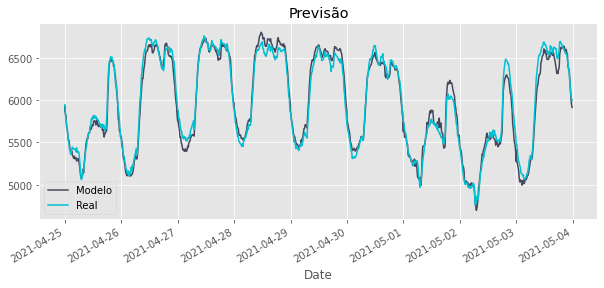

In [ ]:
ax = df_previsao.loc["2021-04-25":"2021-05-03"].plot(
    y="Modelo", figsize=(10, 4), title="Previsão", c=dark_blue, alpha=0.75, label = "Modelo"
)
df_previsao.loc["2021-04-25":"2021-05-03"].plot(
    y="Real", label="Real", color=teal, ax=ax
)

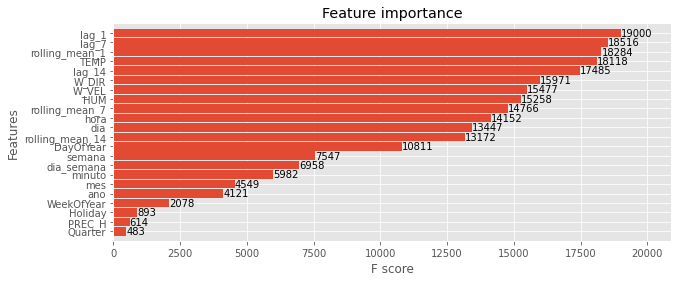

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
def marca_pico(df, coluna_executado="Executado" ):
  df["dataref"] = df['temp'].apply(lambda x: x.strftime('%Y%m%d'))
  df2 = df[(17 <= df.index.hour) & (df.index.hour <= 23)]
  df2[f"max_{coluna_executado}"] = df2.groupby("dataref")[f"{coluna_executado}"].transform("max")
  df2["pico"] = (df2[f"{coluna_executado}"] == df2[f"max_{coluna_executado}"])
  df = df.join(df2['pico'], lsuffix='', rsuffix='')
  df.loc[pd.isnull(df["pico"]), "pico"] = False
  df["pico"] = df["pico"].astype(int)

  return df

In [ ]:
df_previsao['temp'] = df_previsao.index.to_pydatetime()
df_real = df_previsao[['Real','temp']].copy()
df_modelo = df_previsao[['Modelo','temp']].copy()

df_real = marca_pico(df_real, coluna_executado="Real")
df_real_pico = df_real[df_real['pico']==1] 

df_modelo = marca_pico(df_modelo, coluna_executado="Modelo")
df_modelo_pico = df_modelo[df_modelo['pico']==1] 

df_compara_pico =  df_modelo_pico.merge(df_real_pico[["dataref", "temp"]], on="dataref", how="left")
df_compara_pico['error'] = (df_compara_pico['temp_x']- df_compara_pico['temp_y'])
df_compara_pico['error'] = df_compara_pico['error'].apply(lambda x: abs(x.total_seconds()/60))

df_compara_pico['error'].mean()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

48.28125

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


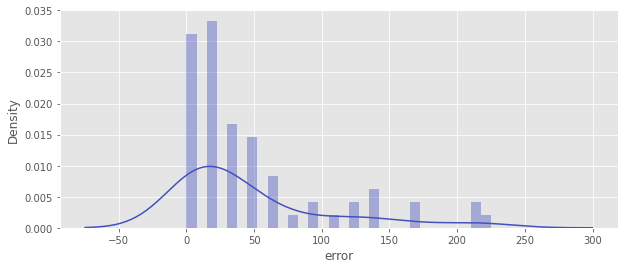

In [ ]:
ax = sns.distplot(
    df_compara_pico['error'], color=light_blue, bins=30
)




#5 - Previsão do dia  03/05/2021

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


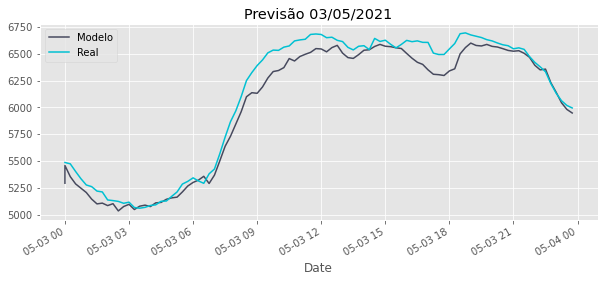

In [ ]:
ax = df_previsao.loc["2021-05-03"].plot(
    y="Modelo", figsize=(10, 4), title="Previsão 03/05/2021", c=dark_blue, alpha=0.75, label = "Modelo"
)
df_previsao.loc["2021-05-03"].plot(
    y="Real", label="Real", color=teal, ax=ax
)